# 3. Train model using PyCaffe
PyCaffe를 이용하여 network architecture(.prototxt)를 생성하고 python 상에 구현된 solver를 이용하여 LeNet을 학습하는 방법을 다룹니다.

* Network가 복잡해 질수록 network architecture에 작성해야할 내용이 많아집니다.
* 본 실습에서는 PyCaffe를 이용하여 python으로 network prototxt를 생성하는 방법을 다루며, python 상에서 이를 학습하는 방법에 대해서 다룹니다.

### 1. Define Model

<img src = './lenet/lenet5.png'>

실습 1번에서 다룬 LeNet의 network 정의 prototxt를 python으로 생성해 보겠습니다.

LeNet의 구조는 아래와 같이 정의할 수 있습니다.

* Conv1: kernel_size=5, num_kernel=20, stride=1
* Pool1: kernel_size=2, stride=2, Max Pooling
* Conv2: kernel_size=5, num_kernel=50, stride=1
* Pool2: kernel_size=2, stride=2, Max Pooling
* ip1  : num_output=500
* ReLU 
* ip2  : num_output=10 # label score prediction
* Loss : Softmaxwithloss

PyCaffe로 Network 정의 prototxt를 생성하기 위해서 필요한 libraries를 import 합니다.

In [2]:
import caffe
import numpy as np
from caffe import layers as L, params as P
from pylab import *
#import matplotlib.pyplot as plt
# display plots in this notebook
%matplotlib inline

/root/caffe/python/caffe/pycaffe.py:13: RuntimeWarning: to-Python converter for boost::shared_ptr<caffe::Net<float> > already registered; second conversion method ignored.
  from ._caffe import Net, SGDSolver, NesterovSolver, AdaGradSolver, \
/root/caffe/python/caffe/pycaffe.py:13: RuntimeWarning: to-Python converter for boost::shared_ptr<caffe::Blob<float> > already registered; second conversion method ignored.
  from ._caffe import Net, SGDSolver, NesterovSolver, AdaGradSolver, \
/root/caffe/python/caffe/pycaffe.py:13: RuntimeWarning: to-Python converter for boost::shared_ptr<caffe::Solver<float> > already registered; second conversion method ignored.
  from ._caffe import Net, SGDSolver, NesterovSolver, AdaGradSolver, \


위의 LeNet 모델은 아래의 python script로 표현이 가능합니다.
(LeNet의 구조와 python script상의 layer parameter를 비교해보세요)

In [3]:
def lenet(lmdb_path, batch_size, phase_flag):
    
    n = caffe.NetSpec()
    ### data input setting
    #### include=[dict(phase)] 를 사용하여 train dataset과 test dataset을 구분하여 생성합니다.
    #phase = 0 : TRAIN
    #phase = 1 : TEST
    if phase_flag == 'TRAIN':
        n.data, n.label = L.Data(batch_size=batch_size, backend=P.Data.LMDB, source=lmdb_path,
                             transform_param=dict(scale=1./255), ntop=2, include=[dict(phase=0)])
    if phase_flag == 'TEST':
        n.data, n.label = L.Data(batch_size=batch_size, backend=P.Data.LMDB, source=lmdb_path,
                             transform_param=dict(scale=1./255), ntop=2, include=[dict(phase=1)])
    
    ### 2 convolutional layer + 2 fully-connected layer
    n.conv1 = L.Convolution(n.data, kernel_size=5, num_output=20, weight_filler=dict(type='xavier'))
    n.pool1 = L.Pooling(n.conv1, kernel_size=2, stride=2, pool=P.Pooling.MAX)
    n.conv2 = L.Convolution(n.pool1, kernel_size=5, num_output=50, weight_filler=dict(type='xavier'))
    n.pool2 = L.Pooling(n.conv2, kernel_size=2, stride=2, pool=P.Pooling.MAX)
    n.ip1 =   L.InnerProduct(n.pool2, num_output=500, weight_filler=dict(type='xavier'))
    n.relu1 = L.ReLU(n.ip1, in_place=True)
    n.ip2 = L.InnerProduct(n.relu1, num_output=10, weight_filler=dict(type='xavier'))
    if phase_flag == 'TEST':
        n.accuracy = L.Accuracy(n.ip2, n.label, include=[dict(phase=1)]) # Test phase에서만 활성화하기 위해 include 문 삽입
    n.loss =  L.SoftmaxWithLoss(n.ip2, n.label)
    
    
    return n.to_proto()

정의된 lenet 함수를 호출하여 prototxt파일을 write합니다.

In [10]:
with open('./lenet/lenet_python_tr.prototxt','w') as f:
    f.write(str(lenet('./lenet/mnist_train_lmdb', 64, 'TRAIN')))
with open('./lenet/lenet_python_te.prototxt','w') as f:
    f.write(str(lenet('./lenet/mnist_test_lmdb', 100, 'TEST')))

생성된 python_lenet_tr.prototxt를 확인하고 이전 실습에서 사용한 lenet_train_test.prototxt와 비교해보세요

In [11]:
!cat ./lenet/lenet_python_tr.prototxt

layer {
  name: "data"
  type: "Data"
  top: "data"
  top: "label"
  include {
    phase: TRAIN
  }
  transform_param {
    scale: 0.00392156862745
  }
  data_param {
    source: "./lenet/mnist_train_lmdb"
    batch_size: 64
    backend: LMDB
  }
}
layer {
  name: "conv1"
  type: "Convolution"
  bottom: "data"
  top: "conv1"
  convolution_param {
    num_output: 20
    kernel_size: 5
    weight_filler {
      type: "xavier"
    }
  }
}
layer {
  name: "pool1"
  type: "Pooling"
  bottom: "conv1"
  top: "pool1"
  pooling_param {
    pool: MAX
    kernel_size: 2
    stride: 2
  }
}
layer {
  name: "conv2"
  type: "Convolution"
  bottom: "pool1"
  top: "conv2"
  convolution_param {
    num_output: 50
    kernel_size: 5
    weight_filler {
      type: "xavier"
    }
  }
}
layer {
  name: "pool2"
  type: "Pooling"
  bottom: "conv2"
  top: "pool2"
  pooling_param {
    pool: MAX
    kernel_size: 2
    stride: 2
  }
}
layer {
  name: "ip1"
  type: "InnerProduct"
  bottom: "pool2"
  top: "ip1"


Solver 정의는 lenet_python_solver.prototxt 를 사용합니다.

In [12]:
!cat ./lenet/lenet_python_solver.prototxt

# The train/test net protocol buffer definition
train_net: "./lenet/lenet_python_tr.prototxt"
test_net: "./lenet/lenet_python_te.prototxt"
# test_iter specifies how many forward passes the test should carry out.
# In the case of MNIST, we have test batch size 100 and 100 test iterations,
# covering the full 10,000 testing images.
test_iter: 100
# Carry out testing every 500 training iterations.
test_interval: 500
# The base learning rate, momentum and the weight decay of the network.
base_lr: 0.01
momentum: 0.9
weight_decay: 0.0005
# The learning rate policy
lr_policy: "inv"
gamma: 0.0001
power: 0.75
# Display every 100 iterations
display: 100
# The maximum number of iterations
max_iter: 10000
# snapshot intermediate results
snapshot: 5000
snapshot_prefix: "./lenet/lenet"
# solver mode: CPU or GPU
solver_mode: CPU


PyCaffe의 SGD Solver는 아래처럼 solver prototext 파일로부터 초기화 할 수 있습니다.

In [17]:
caffe.set_mode_cpu()
solver = None # PyCaffe에서 SGDSolver가 미리 정의되어 있는 상태로 재정의를 하면 오류가 발생합니다. 이를 방지하기 위해서 실행합니다.
solver = caffe.SGDSolver('./lenet/lenet_python_solver.prototxt')

PyCaffe를 사용하여 학습하는 예제입니다. Python으로 학습 loop를 수행하므로, `./caffe/build/tools/caffe train` 으로 학습하는 경우보다 더 많은 부분을 조정 할 수 있습니다.
예를 들어
* 매 training step마다의 loss를 저장하여 learning curve 그래프를 쉽게 그릴 수 있습니다.
* Max iter가 아니라, validation set의 loss를 기준으로 하는 stop creterion을 설정할 수 있습니다.
* Network weights를 정해진 loop마다 저장하는 것이 아니라, validation loss가 가장 작을때에 저장할 수 있습니다.

In [18]:
niter = 200 # Max iteration Number를 10000에서 200번으로 재정의 합니다.
test_interval = 25 # 매 25번 training loop마다 test set에 대해 성능을 측정합니다.
train_loss = np.zeros(niter) # traiing loss를 저장하는 변수입니다
test_acc = np.zeros(int(np.ceil(niter / test_interval))) # training acc를 저장하는 변수입니다.

for i in xrange(niter):
    solver.step(1)
    train_loss[i] = solver.net.blobs['loss'].data # Train net의 loss blob을 가져와 저장합니다.
    if i % test_interval == 0:
        correct = 0
        for test_i in xrange(100):
            solver.test_nets[0].forward()
            correct += sum(solver.test_nets[0].blobs['ip2'].data.argmax(1) == solver.test_nets[0].blobs['label'].data)
            test_acc[i // test_interval] = correct / 1e4
        print 'Iteration', i, 'testing acc: ', test_acc[i // test_interval]

Iteration 0 testing acc:  0.1064
Iteration 25 testing acc:  0.7975
Iteration 50 testing acc:  0.8613
Iteration 75 testing acc:  0.8974
Iteration 100 testing acc:  0.9191
Iteration 125 testing acc:  0.9363
Iteration 150 testing acc:  0.9308
Iteration 175 testing acc:  0.9376


PyCaffe의 확장성을 이용하여 Iteration마다의 Train loss와 Test accuracy를 그리는 코드입니다.

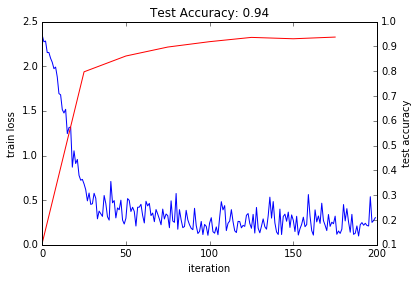

In [20]:
_, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(arange(niter), train_loss)
ax2.plot(test_interval * arange(len(test_acc)), test_acc, 'r')
ax1.set_xlabel('iteration')
ax1.set_ylabel('train loss')
ax2.set_ylabel('test accuracy')
ax2.set_title('Test Accuracy: {:.2f}'.format(test_acc[-1]))

PyCaffe를 이용한 LeNet 학습을 성공적으로 수행하셨습니다.
### Excercise) `def lenet` 함수를 변경하여 network의 구조를 변경해 보세요. layer를 추가하고 hidden node의 개수를 쉽게 변경할 수 있습니다.
### 변경한 모델에 대해서 학습을 진행하고 성능을 측정해 보세요